# Anomaly calculations

In [1]:
# Imports
from earthkit import transforms as ekt
from earthkit import data as ekd
from earthkit.data.testing import earthkit_remote_test_data_file
ekd.settings.set("cache-policy", "user")

## Load some test data

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with a pre-loaded `xarray`. To reduce the number of conversions in the example, we will convert to xarray in the first cell and use that data object for all subsequent steps.

In [2]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_france_2015_2016_2017_3deg.grib")
era5_data = ekd.from_source("url", remote_era5_file)

# convert to xarray to save repeated conversion in further steps
era5_xr = era5_data.to_xarray(time_dim_mode="valid_time")
era5_xr

<xarray.Dataset> Size: 217kB
Dimensions:     (valid_time: 542, latitude: 7, longitude: 7)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 2015-01-01 ... 2017-03-31T12:...
  * latitude    (latitude) float64 56B 48.0 45.0 42.0 39.0 36.0 33.0 30.0
  * longitude   (longitude) float64 56B 0.0 3.0 6.0 9.0 12.0 15.0 18.0
Data variables:
    2t          (valid_time, latitude, longitude) float64 212kB ...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Calculate the daily climatology of the ERA5 data

In [3]:
climatology_daily_mean = ekt.climatology.daily_mean(era5_xr)
climatology_daily_mean

<xarray.Dataset> Size: 37kB
Dimensions:    (dayofyear: 91, latitude: 7, longitude: 7)
Coordinates:
  * latitude   (latitude) float64 56B 48.0 45.0 42.0 39.0 36.0 33.0 30.0
  * longitude  (longitude) float64 56B 0.0 3.0 6.0 9.0 12.0 15.0 18.0
  * dayofyear  (dayofyear) int64 728B 1 2 3 4 5 6 7 8 ... 85 86 87 88 89 90 91
Data variables:
    2t         (dayofyear, latitude, longitude) float64 36kB 274.9 ... 292.7
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Calculate the anomaly and relative anomaly

In [4]:
anomaly = ekt.climatology.anomaly(era5_xr, climatology_daily_mean)
anomaly

<xarray.Dataset> Size: 329kB
Dimensions:     (latitude: 7, longitude: 7, valid_time: 821)
Coordinates:
  * latitude    (latitude) float64 56B 48.0 45.0 42.0 39.0 36.0 33.0 30.0
  * longitude   (longitude) float64 56B 0.0 3.0 6.0 9.0 12.0 15.0 18.0
  * valid_time  (valid_time) datetime64[ns] 7kB 2015-01-01 ... 2017-03-31
Data variables:
    2t          (valid_time, latitude, longitude) float64 322kB -1.105 ... -2...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

In [5]:
relative_anomaly = ekt.climatology.relative_anomaly(
    era5_xr, climatology_daily_mean
)
relative_anomaly

<xarray.Dataset> Size: 329kB
Dimensions:     (latitude: 7, longitude: 7, valid_time: 821)
Coordinates:
  * latitude    (latitude) float64 56B 48.0 45.0 42.0 39.0 36.0 33.0 30.0
  * longitude   (longitude) float64 56B 0.0 3.0 6.0 9.0 12.0 15.0 18.0
  * valid_time  (valid_time) datetime64[ns] 7kB 2015-01-01 ... 2017-03-31
Data variables:
    2t          (valid_time, latitude, longitude) float64 322kB -0.402 ... -1...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Plot the output for a random location

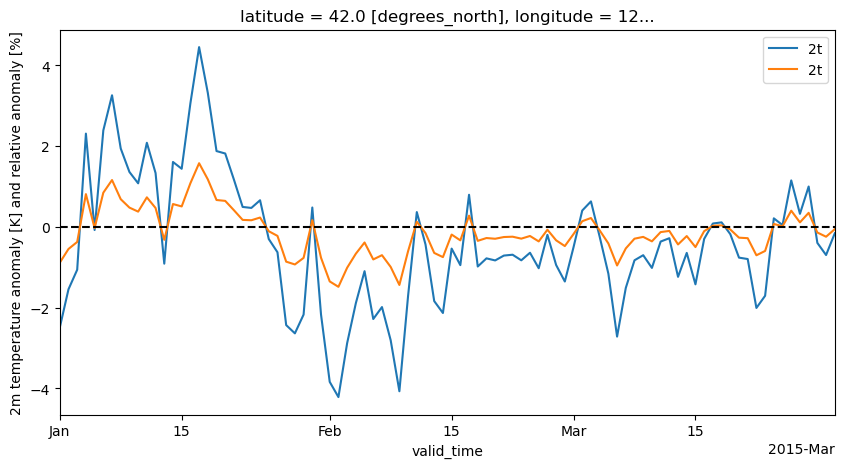

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime

start, end = datetime(2015,1,1), datetime(2015,3,31)

isel_kwargs = {"latitude":2, "longitude":4}
sel_kwargs = {"valid_time": slice(start, end)}

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

for data in [anomaly, relative_anomaly]:
    var_name = list(data.data_vars.keys())[0]
    p_data = data[var_name].isel(**isel_kwargs).sel(**sel_kwargs)
    p_data.plot(ax=ax, label=var_name)

ax.set_xlim(start, end)
ax.set_ylabel("2m temperature anomaly [K] and relative anomaly [%]")
ax.hlines(0, xmin=start, xmax=end, color="black", linestyle="--")
ax.legend()

